# Preprocessing of the raw training data

## 1. Loading libraries, parameters and data

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import json

from joblib import Parallel, delayed

from scipy.signal import savgol_filter

In [2]:
from ddae1d.utils import despike_iterative
from ddae1d.paths import PROJECT_ROOT

### Loading parameters

Modify them in `./config.json` if needed.

In [3]:
with open("config.json", "r") as f:
    config = json.load(f)

In [4]:
raw_trainset_filename = config["raw_trainset_filename"]

trim_spectra = config["trim_spectra"]
spectral_ends = config["spectral_ends"]

apply_savgol = config["apply_savgol"]
savgol_params = config["savgol_params"]

apply_despike = config["apply_despike"]
n_jobs_despike = config["n_jobs_despike"]
despike_params = config["despike_params"]

### Loading raw training data

In [5]:
raw_trainset = np.load(PROJECT_ROOT / "data" / "raw" / "trainset" / raw_trainset_filename)

## 2. Trimming spectral ends and substracting offset

### *If needed, trim the spectral ends to remove artefacts such as Rayleigh scattering*

Modify the values of `trim_spectra` and `spectral_ends` in `./config.json` if needed.

In [6]:
if trim_spectra:
    # Trim spectral ends
    trainset = raw_trainset[:, :, spectral_ends[0]:spectral_ends[1]]
else:
    trainset = raw_trainset

In [7]:
del raw_trainset

***It is necessary for the resulting number of spectral channels to be divisible by the highest possible power of 2, for the autoencoder architecture to work properly. Indeed, the encoding and decoding process involves multiple downsampling and upsampling steps, typically by a factor of 2. If the input size is not compatible with these operations, it can lead to issues such as mismatched dimensions during the reconstruction phase.***

### *If relevant, subtract an 'offset' baseline - common to the whole dataset. This should be done from the raw spectra before further preprocessing.*

#### Suggested method for computing the offset: Savitzky-Golay smoothed spectrum with lowest mean intensity

*Tune Savitzky-Golay filter parameters in `config.json`*

Index of spectrum with lowest mean intensity: (650, 18)
Savitzky-Golay filter parameters: {'window_length': 111, 'polyorder': 3}


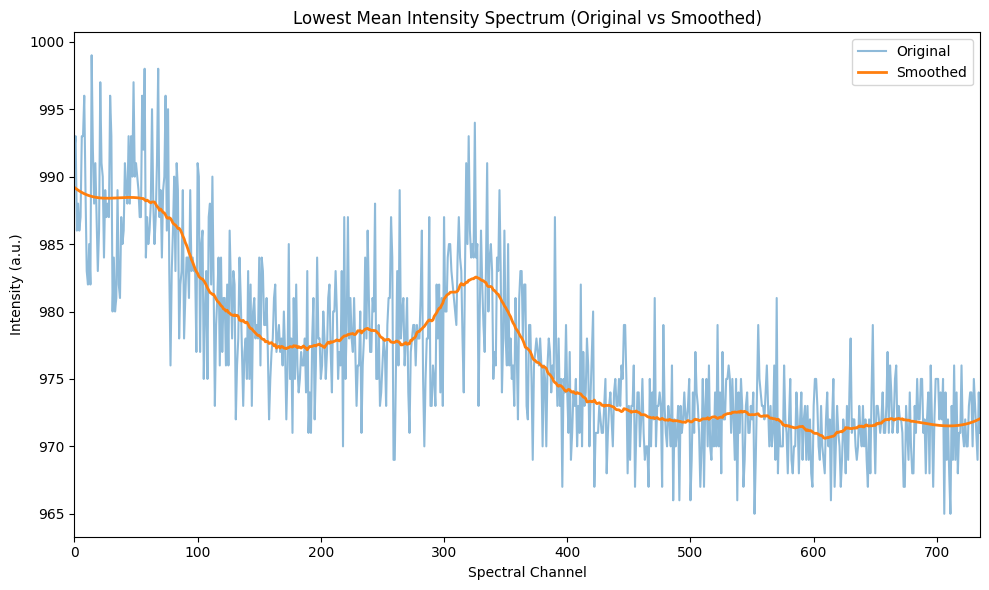

In [8]:
# If Savitzky-Golay smoothing is enabled, subtract a smoothed baseline from all spectra
if apply_savgol:
    # Find the index of the spectrum with the lowest mean intensity
    lowest_mean_idx = tuple(int(arr[0]) for arr in np.where(np.nanmean(trainset, axis=2) == np.nanmean(trainset, axis=2).min()))
    print(f"Index of spectrum with lowest mean intensity: {lowest_mean_idx}")

    # Extract the spectrum with the lowest mean intensity
    lowest_mean_spectrum = trainset[lowest_mean_idx]

    # Show the Savitzky-Golay filter parameters
    print(f"Savitzky-Golay filter parameters: {savgol_params}")

    # Smooth the lowest mean intensity spectrum using Savitzky-Golay filter
    smoothed_spectrum = savgol_filter(lowest_mean_spectrum, **savgol_params)

    # Plot the original and smoothed spectrum for visual inspection
    plt.figure(figsize=(10, 6))
    plt.plot(lowest_mean_spectrum, label="Original", alpha=0.5)
    plt.plot(smoothed_spectrum, label="Smoothed", linewidth=2)
    plt.xlabel("Spectral Channel")
    plt.ylabel("Intensity (a.u.)")
    plt.title("Lowest Mean Intensity Spectrum (Original vs Smoothed)")
    plt.xlim(0, len(lowest_mean_spectrum) - 1)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Subtract the smoothed baseline from all spectra in the training set
    trainset_after_offset = trainset - smoothed_spectrum
else:
    trainset_after_offset = trainset

In [9]:
del trainset

## 3. Despiking (parallel processing)

Tune the number of parallel jobs: `n_jobs_despike` in `config.json`

In [10]:
def despike_task(point, repetition):
    despiked_spectrum, spikes_spectrum = despike_iterative(
        trainset_after_offset[point, repetition, :],
        **despike_params
    )
    return (point, repetition, despiked_spectrum, spikes_spectrum)

In [11]:
if apply_despike:
    print(f"Number of jobs for parallel despiking: {n_jobs_despike % (os.cpu_count() + 1)}")
    spikes = np.zeros_like(trainset_after_offset)
    trainset_after_despike = np.zeros_like(trainset_after_offset)
    print("Starting parallel despiking of final map...")
    print(f"Total spectra to despike (tasks to do): {trainset_after_offset.shape[0]}")
    results = Parallel(n_jobs=n_jobs_despike, verbose=1)(
        delayed(despike_task)(point, repetition)
        for point in range(trainset_after_offset.shape[0])
        for repetition in range(trainset_after_offset.shape[1])
    )
    for point, repetition, despiked_spectrum, spikes_spectrum in results:
        trainset_after_despike[point, repetition, :] = despiked_spectrum
        spikes[point, repetition, :] = spikes_spectrum
    del results
    nonzero_indices = np.argwhere(np.any(spikes != 0, axis=2)).squeeze()
    percentage_nonzero = len(nonzero_indices) / (trainset_after_despike.shape[0] * trainset_after_despike.shape[1]) * 100
    print(f"Percentage of spectra despiked: {percentage_nonzero:.2f}%")
    print("Number of spectra despiked:", len(nonzero_indices))
else:
    trainset_after_despike = trainset_after_offset

Number of jobs for parallel despiking: 18
Starting parallel despiking of final map...
Total spectra to despike (tasks to do): 704


[Parallel(n_jobs=-5)]: Using backend LokyBackend with 18 concurrent workers.


[Parallel(n_jobs=-5)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-5)]: Done 336 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-5)]: Done 6930 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-5)]: Done 13790 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-5)]: Done 14080 out of 14080 | elapsed:    8.8s finished


Percentage of spectra despiked: 0.48%
Number of spectra despiked: 67
